# Demand Forecasting
___

In this section, we'll discuss the importance of demand forecasting for Airbnb accommodations in Berlin. Demand forecasting enables hosts to anticipate fluctuations in demand, optimize pricing strategies, and maximize revenue potential.

## Why Demand Forecasting Matters

Demand forecasting provides invaluable insights into future booking trends, allowing hosts to adjust pricing and availability to meet anticipated demand. By understanding when and where demand is likely to be high or low, hosts can make informed decisions to optimize their listings and maximize occupancy rates.

## Objectives

Our objective is to develop accurate demand forecasts for Airbnb accommodations in Berlin. By leveraging historical booking data and predictive analytics, we aim to provide actionable insights to hosts, empowering them to optimize their pricing, availability, and marketing strategies.

In [4]:
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pandas as pd
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [5]:
sales = pd.read_csv('../data/04_sales.csv')

# Preliminary Graphing
___

Text(0, 0.5, 'Sales (in millions $)')

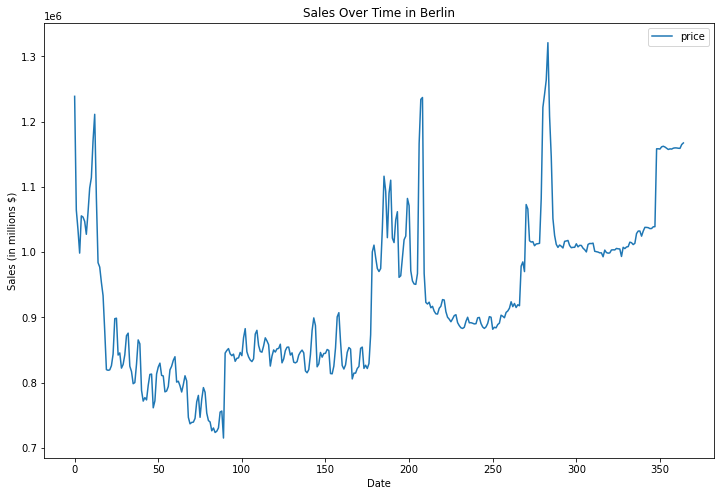

In [6]:
ax = sales.plot(figsize=(12, 8))

ax.set_title('Sales Over Time in Berlin')
ax.set_xlabel('Date')
ax.set_ylabel('Sales (in millions $)')

In the preceding graph, we observe subtle weekly fluctuations, hinting at increased sales during weekends. Notable spikes coincide with significant events such as Christmas and New Year, the summer season, and early October, likely due to Oktoberfest celebrations.

Text(0, 0.5, 'Sales')

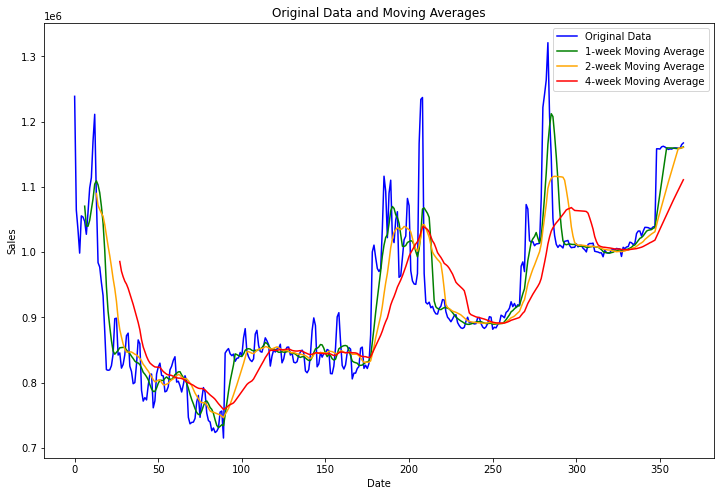

In [7]:
# Calculate moving averages
sales['1_week_avg'] = sales['price'].rolling(window=7).mean()
sales['2_week_avg'] = sales['price'].rolling(window=14).mean()
sales['4_week_avg'] = sales['price'].rolling(window=28).mean()

plt.figure(figsize=(12, 8))

plt.plot(sales['price'], label='Original Data', color='blue')
plt.plot(sales['1_week_avg'], label='1-week Moving Average', color='green')
plt.plot(sales['2_week_avg'], label='2-week Moving Average', color='orange')
plt.plot(sales['4_week_avg'], label='4-week Moving Average', color='red')

plt.legend()

plt.title('Original Data and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Sales')

Even after we enact moving averages we see these spikes 

# Seasonality 
We must first decide if there is seasonality present in our data since this will dictate which kind of model we will use. To answer this question, we look at the autocorrelation and partial autocorrelation plots. Autocorrelation is the correlation between the data and its lag. Partial autocorrelation is the same except we remove the correlation from short term lags. 

Seasonality is indicated by significant spikes or sudden drops in correlation at specific lag intervals.

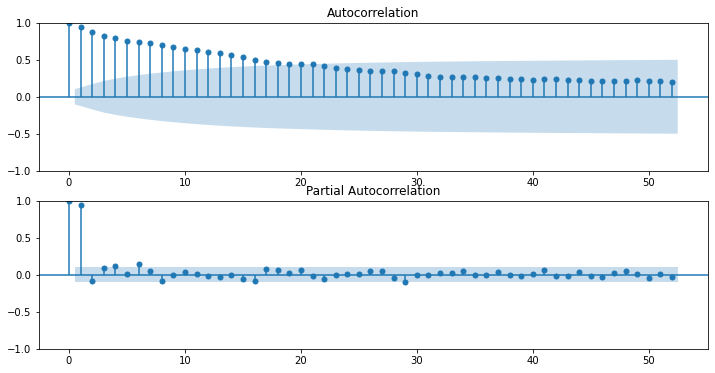

In [8]:
acf = sm.tsa.acf(sales['price'], nlags=52)
pacf = sm.tsa.pacf(sales['price'], nlags=52)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(sales['price'], lags=52, ax=plt.gca())

plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(sales['price'], lags=52, ax=plt.gca())

plt.show()

It appears that our data is seasonal because of the periodic spikes at the beginning of the autocorrelation. Additionally, in the partial autocorrelation plot, we see a sharp drop in the beginning.

# Forecasting
___

Now that we have found seasonality in our data we can justifiably use a SARIMA model. SARIMA (Seasonal Autoregressive Integrated Moving Average) is a good forecasting model for data with seasonality because it can effectively capture both the short-term and long-term patterns in the data. 

In [9]:
sales['date'] = pd.to_datetime(sales['date'])
sales.set_index('date', inplace=True)

In [10]:
# Split the data into train and test sets
train, test = train_test_split(sales, train_size=0.8)

In [11]:
# Split the data into train and test sets
train, test = train_test_split(sales['price'], train_size=0.8)  # Use only the 'price' column for training and testing

# Use Holt-Winters method to find best SARIMA parameters
model = pm.auto_arima(train, seasonal=True, m=12, method='nm', stepwise=True, suppress_warnings=True)

# Get the best SARIMA parameters
best_params = model.get_params()

# Fit SARIMA model with best parameters
sarima_model = pm.ARIMA(order=best_params['order'], seasonal_order=best_params['seasonal_order'])
sarima_model.fit(train)

# Forecast using SARIMA model
sarima_preds = sarima_model.predict(len(test))

# Evaluate forecast using Mean Squared Error (MSE)
mse_score = mean_squared_error(test, sarima_preds)

print("Best SARIMA parameters:", best_params)
print("MSE score:", mse_score)

Best SARIMA parameters: {'maxiter': 50, 'method': 'nm', 'order': (3, 1, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 12), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}
MSE score: 5722733838.35486


/Users/tannerzuleeg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/tannerzuleeg/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


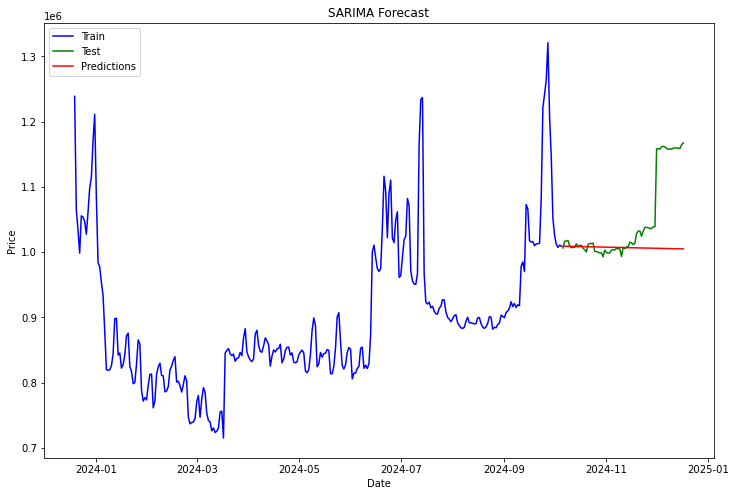

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(train, label='Train', color='blue')
plt.plot(test, label='Test', color='green')
plt.plot(sarima_preds, label='Predictions', color='red')
plt.legend(loc='upper left')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
